In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
data_normal_1 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_2.csv')
data_normal_3 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_3.csv')
data_normal_4 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_4.csv')
data_normal_5 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_normal_1.csv')
data_normal_6 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_normal_2.csv')
data_normal_7 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_normal_3.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_attack_2.csv')
data_attack_3 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_attack_3.csv')
data_attack_4 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_attack_1.csv')
data_attack_5 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_attack_2.csv')

data_normal_1.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_normal_2.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_normal_3.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_normal_4.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']

data_normal_5.columns=['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']
data_normal_6.columns=['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']
data_normal_7.columns=['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']


data_attack_1.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_attack_2.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_attack_3.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']

data_attack_4.columns=['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']
data_attack_5.columns=['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']

data_normal_5=data_normal_5.drop(['timestamp', 'port_dest'],axis=1)
data_normal_6=data_normal_6.drop(['timestamp', 'port_dest'],axis=1)
data_normal_7=data_normal_7.drop(['timestamp', 'port_dest'],axis=1)

data_attack_4=data_attack_4.drop(['timestamp', 'port_dest'],axis=1)
data_attack_5=data_attack_5.drop(['timestamp', 'port_dest'],axis=1)

features = ['port_src', 'len', 'chksum', 'payload_len']

In [3]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values
X_normal_3 = data_normal_3[features].values
X_normal_4 = data_normal_4[features].values
X_normal_5 = data_normal_5[features].values
X_normal_6 = data_normal_6[features].values
X_normal_7 = data_normal_7[features].values
X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values
X_attack_3 = data_attack_3[features].values
X_attack_4 = data_attack_4[features].values
X_attack_5 = data_attack_5[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']
Y_normal_3 = data_normal_3['label']
Y_normal_4 = data_normal_4['label']
Y_normal_5 = data_normal_5['label']
Y_normal_6 = data_normal_6['label']
Y_normal_7 = data_normal_7['label']
Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']
Y_attack_3 = data_attack_3['label']
Y_attack_4 = data_attack_4['label']
Y_attack_5 = data_attack_5['label']

X = np.concatenate((X_normal_1,X_normal_2,X_normal_3,X_normal_4,X_normal_5,X_normal_6,X_normal_7,X_attack_1,X_attack_2,X_attack_3,X_attack_4,X_attack_5))
Y = np.concatenate((Y_normal_1,Y_normal_2,Y_normal_3,Y_normal_4,Y_normal_5,Y_normal_6,Y_normal_7,Y_attack_1,Y_attack_2,Y_attack_3,Y_attack_4,Y_attack_5))

In [4]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [5]:
print(np.shape(X))
print(np.shape(Y))

(145308, 4)
(145308,)


In [6]:
features = len(X[0])
samples = X.shape[0]
train_len = 200
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

print(I.shape)

(145108, 200, 4)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[200:], test_size = 0.2, stratify=Y[200:], random_state = 0)

In [8]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [9]:
model = create_baseline()

In [10]:
history = model.fit(X_train, Y_train, epochs = 5,validation_split=0.2, verbose = 1)

Epoch 1/5
2903/2903 [==============================] - 82s 27ms/step - loss: 0.2176 - accuracy: 0.9524 - val_loss: 0.1710 - val_accuracy: 0.9543
Epoch 2/5
2903/2903 [==============================] - 76s 26ms/step - loss: 0.2501 - accuracy: 0.9344 - val_loss: 0.1267 - val_accuracy: 0.9857
Epoch 3/5
2903/2903 [==============================] - 76s 26ms/step - loss: 0.1565 - accuracy: 0.9736 - val_loss: 0.1498 - val_accuracy: 0.9741
Epoch 4/5
2903/2903 [==============================] - 80s 27ms/step - loss: 0.1762 - accuracy: 0.9601 - val_loss: 0.1244 - val_accuracy: 0.9845
Epoch 5/5
2903/2903 [==============================] - 80s 28ms/step - loss: 0.2207 - accuracy: 0.9399 - val_loss: 0.2241 - val_accuracy: 0.9590


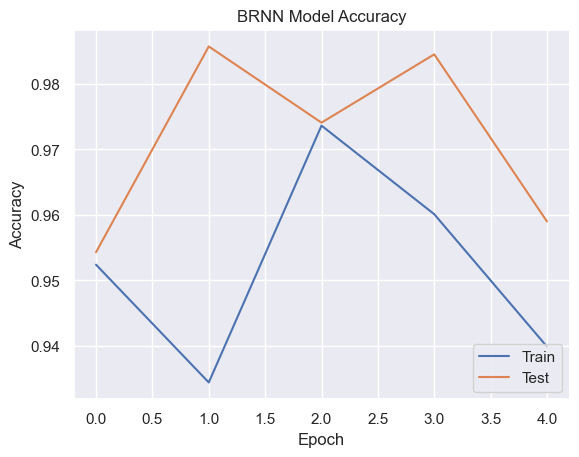

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

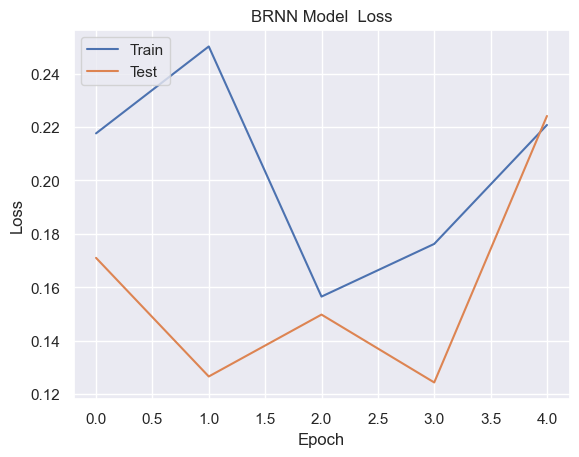

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()

In [13]:
predict = model.predict(X_test, verbose=1)

907/907 [==============================] - 11s 12ms/step


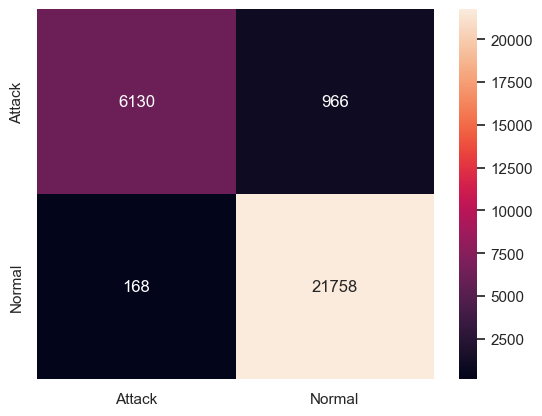

In [14]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

figure = ax.get_figure()    
# figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [15]:
# model.save('brnn_model.h5')
# joblib.dump(scalar, 'scaler.save') 

In [16]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 96.09%
